In [17]:
from keras import applications
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.callbacks import CSVLogger
import tensorflow as tf
from scipy.ndimage import imread
import numpy as np
import random
from keras.layers import LSTM
from keras.layers import Conv1D, MaxPooling1D
from keras import backend as K
import keras
from keras.callbacks import CSVLogger, ModelCheckpoint
from keras.backend.tensorflow_backend import set_session
from keras import optimizers
import h5py
from sklearn.preprocessing import MinMaxScaler
import os
import pandas as pd
# import matplotlib

import matplotlib.pyplot as plt

In [18]:
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

In [19]:
with h5py.File(''.join(['bitcoin2012_2017_256_16.h5']), 'r') as hf:
    datas = hf['inputs'].value
    labels = hf['outputs'].value
    input_times = hf['input_times'].value
    output_times = hf['output_times'].value
    original_inputs = hf['original_inputs'].value
    original_outputs = hf['original_outputs'].value
    original_datas = hf['original_datas'].value

In [20]:
scaler=MinMaxScaler()
#split training validation
training_size = int(0.8* datas.shape[0])
training_datas = datas[:training_size,:,:]
training_labels = labels[:training_size,:,:]
validation_datas = datas[training_size:,:,:]
validation_labels = labels[training_size:,:,:]
validation_original_outputs = original_outputs[training_size:,:,:]
validation_original_inputs = original_inputs[training_size:,:,:]
validation_input_times = input_times[training_size:,:,:]
validation_output_times = output_times[training_size:,:,:]

In [21]:
ground_true = np.append(validation_original_inputs,validation_original_outputs, axis=1)
ground_true.shape

(736, 272, 4)

In [22]:
ground_true_times = np.append(validation_input_times,validation_output_times, axis=1)
ground_true_times.shape

(736, 272, 1)

In [23]:
step_size = datas.shape[1]
batch_size= 8
nb_features = datas.shape[2]
epochs = 1

In [24]:
#build model
model = Sequential()
model.add(Conv1D(activation="relu", input_shape=(step_size, nb_features), strides=3	, filters=8, kernel_size=8))
model.add(Dropout(0.25))
model.add(Conv1D(activation="relu", strides=2, filters=8, kernel_size=8))
model.add(Dropout(0.25))
model.add(Conv1D( strides=2, filters=4, kernel_size=8))
model.load_weights('weights/bitcoin2012_2017_256_16_CNNweights-improvement-03-0.00006.hdf5')
model.compile(loss='mse', optimizer='adam')

In [25]:
predicted = model.predict(validation_datas)
predicted_inverted = []

# In[7]:
for i in range(original_datas.shape[1]):
    scaler.fit(original_datas[:,i].reshape(-1,1))
    predicted_inverted.append(scaler.inverse_transform(predicted[:,:,i]))
print np.array(predicted_inverted).shape
#get only the close data
ground_true = ground_true[:,:,0].reshape(-1)
ground_true_times = ground_true_times.reshape(-1)
ground_true_times = pd.to_datetime(ground_true_times, unit='s')
# since we are appending in the first dimension
predicted_inverted = np.array(predicted_inverted)[0,:,:].reshape(-1)
print np.array(predicted_inverted).shape
validation_output_times = pd.to_datetime(validation_output_times.reshape(-1), unit='s')

(4, 736, 16)
(11776,)


In [26]:
ground_true_df = pd.DataFrame()
ground_true_df['times'] = ground_true_times
ground_true_df['value'] = ground_true
ground_true_df.set_index('times').reset_index()
ground_true_df.shape

(200192, 2)

In [27]:
prediction_df = pd.DataFrame()
prediction_df['times'] = validation_output_times
prediction_df['value'] = predicted_inverted
prediction_df.shape

(11776, 2)

In [28]:
prediction_df.head()

,times,value
0,2016-12-13 20:46:00,790.278442
1,2016-12-13 20:48:00,789.655701
2,2016-12-13 20:50:00,788.909790
3,2016-12-13 20:51:00,788.585876
4,2016-12-13 20:52:00,788.431519


In [29]:
prediction_df = prediction_df.loc[(prediction_df["times"].dt.year == 2016 )&(prediction_df["times"].dt.month > 5 ),: ]
ground_true_df = ground_true_df.loc[(ground_true_df["times"].dt.year == 2016 )&(ground_true_df["times"].dt.month > 5 ),:]

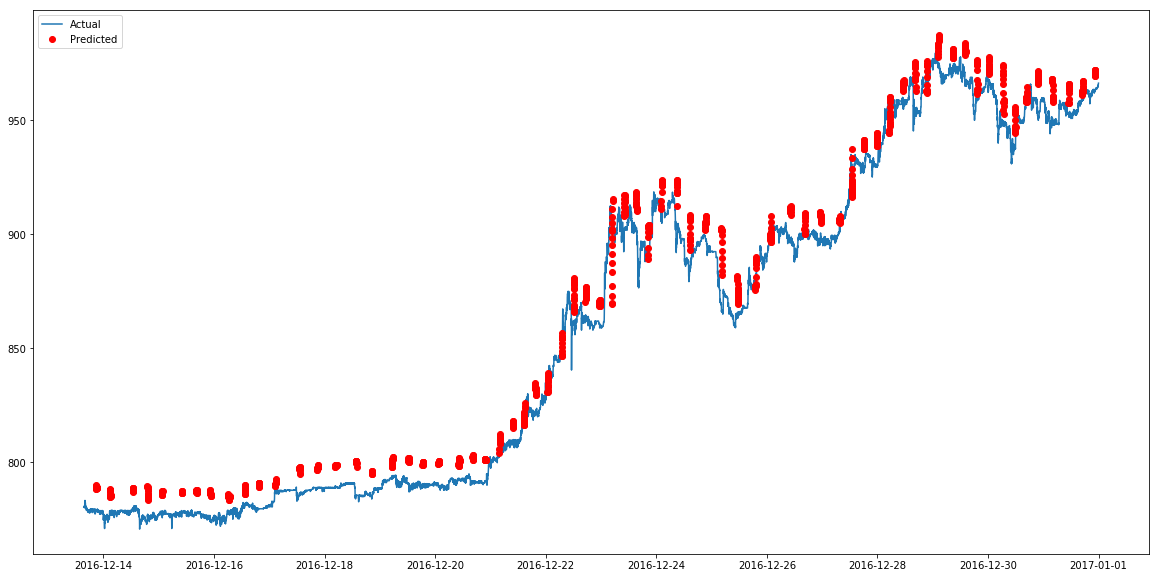

In [30]:
plt.figure(figsize=(20,10))
plt.plot(ground_true_df.times,ground_true_df.value, label = 'Actual')
plt.plot(prediction_df.times,prediction_df.value,'ro', label='Predicted')
plt.legend(loc='upper left')
plt.savefig('result/bitcoin2012_2017_256_16_CNN_result.png')
plt.show()

In [31]:
from sklearn.metrics import mean_squared_error
mean_squared_error(validation_original_outputs[:,:,0].reshape(-1),predicted_inverted)

400.02668260041395